In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os

# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [2]:
import joblib

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv'.format(weather, year))

In [4]:
meso = [read_merged("meso", year) for year in range(2015, 2023)]

In [5]:
data = pd.concat(meso)
del meso

In [6]:
del data['Unnamed: 0']
del data['index']
data['TVS_max'] = 1*(data['TVS_max'] == 'Y')
data['DATE'] = pd.to_datetime(data['DATE'])
data['Month'] = data['DATE'].dt.month

In [7]:
data['y'] = 0

data.loc[data.power_outage == True, 'y']=1

In [8]:
all_features =([data.columns[1], 
                data.columns[2]] +
                data.columns[4:13].tolist() +
                [data.columns[16]])

In [9]:
all_features

['LAT_mean',
 'LON_mean',
 'LL_ROT_VEL_max',
 'LL_DV_max',
 'LL_BASE_max',
 'DEPTH_KFT_max',
 'DPTH_STMRL_max',
 'MAX_RV_KFT_max',
 'MAX_RV_KTS_max',
 'TVS_max',
 'MSI_max',
 'Month']

In [10]:
meso_train, meso_test = train_test_split(data.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.2,
                                              stratify=data.y.values)

In [11]:
meso_tt, meso_val = train_test_split(meso_train.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.2,
                                              stratify=meso_train.y.values)

In [12]:
outage = meso_tt[meso_tt['power_outage']==True]
no_outage = meso_tt[meso_tt['power_outage']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
meso_tt_balanced = pd.concat([outage,no_outage],axis=0)

In [13]:
n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=498)

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
max_depths = range(1, 11)
n_trees = [100, 500]

rf_accs = np.zeros((n_splits, len(max_depths), len(n_trees)))

rf_reccs = np.zeros((n_splits, len(max_depths), len(n_trees)))

rf_precis = np.zeros((n_splits, len(max_depths), len(n_trees)))



for i,(train_index, test_index) in enumerate(kfold.split(meso_tt_balanced, meso_tt_balanced.y)):
    print("CV Split", i)
    meso_bal_tt = meso_tt_balanced.iloc[train_index]
    meso_ho = meso_tt_balanced.iloc[test_index]

    for j, max_depth in enumerate(max_depths):
        for k, n_estimators in enumerate(n_trees):
            print(i,j,k)
            rf = RandomForestClassifier(n_estimators = n_estimators,
                                           max_depth = max_depth,
                                           max_samples = 0.8,
                                           random_state = 216)
                                           
            rf.fit(meso_bal_tt[all_features], meso_bal_tt.y)
            
            pred = rf.predict(meso_ho[all_features])
            
            rf_accs[i,j,k] = accuracy_score(meso_ho.y,  pred)

            rf_reccs[i,j,k] = accuracy_score(meso_ho.y,  pred)

            rf_precis[i,j,k] = accuracy_score(meso_ho.y,  pred)

CV Split 0
0 0 0
0 0 1
0 1 0
0 1 1
0 2 0
0 2 1
0 3 0
0 3 1
0 4 0
0 4 1
0 5 0
0 5 1
0 6 0
0 6 1
0 7 0
0 7 1
0 8 0
0 8 1
0 9 0
0 9 1
CV Split 1
1 0 0
1 0 1
1 1 0
1 1 1
1 2 0
1 2 1
1 3 0
1 3 1
1 4 0
1 4 1
1 5 0
1 5 1
1 6 0
1 6 1
1 7 0
1 7 1
1 8 0
1 8 1
1 9 0
1 9 1
CV Split 2
2 0 0
2 0 1
2 1 0
2 1 1
2 2 0
2 2 1
2 3 0
2 3 1
2 4 0
2 4 1
2 5 0
2 5 1
2 6 0
2 6 1
2 7 0
2 7 1
2 8 0
2 8 1
2 9 0
2 9 1
CV Split 3
3 0 0
3 0 1
3 1 0
3 1 1
3 2 0
3 2 1
3 3 0
3 3 1
3 4 0
3 4 1
3 5 0
3 5 1
3 6 0
3 6 1
3 7 0
3 7 1
3 8 0
3 8 1
3 9 0
3 9 1
CV Split 4
4 0 0
4 0 1
4 1 0
4 1 1
4 2 0
4 2 1
4 3 0
4 3 1
4 4 0
4 4 1
4 5 0
4 5 1
4 6 0
4 6 1
4 7 0
4 7 1
4 8 0
4 8 1
4 9 0
4 9 1


In [16]:
max_acc_index = np.unravel_index(np.argmax(np.mean(rf_accs, axis=0)), 
                                       np.mean(rf_accs, axis=0).shape)


print(max_depths[max_acc_index[0]],n_trees[max_acc_index[1]])

10 100


In [17]:
max_recall_index = np.unravel_index(np.argmax(np.mean(rf_reccs, axis=0)), 
                                       np.mean(rf_reccs, axis=0).shape)


print(max_depths[max_recall_index[0]],n_trees[max_recall_index[1]])

10 100


In [18]:
max_precis_index = np.unravel_index(np.argmax(np.mean(rf_precis, axis=0)), 
                                       np.mean(rf_precis, axis=0).shape)


print(max_depths[max_precis_index[0]],n_trees[max_precis_index[1]])

10 100


In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
max_depths_more = range(10,16)
n_trees_more=[200,300,400]

In [17]:
grid_cv = GridSearchCV(RandomForestClassifier(),
                          param_grid = {'max_depth':max_depths_more, 
                                        'n_estimators':n_trees_more},
                          scoring = 'accuracy', verbose=15, n_jobs=6,
                          cv = 3)


grid_cv.fit(meso_tt_balanced[all_features], meso_tt_balanced.y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': range(10, 16),
                         'n_estimators': [200, 300, 400]},
             scoring='accuracy', verbose=15)

In [25]:
grid_cv.best_params_

{'max_depth': 15, 'n_estimators': 300}

In [19]:
grid_cv.best_score_

0.7982931923503687

In [20]:
grid_cv.best_estimator_

RandomForestClassifier(max_depth=15, n_estimators=300)

In [21]:
grid_cv.best_estimator_.predict(meso_val[all_features])

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
pd.DataFrame({'feature_importance_score':grid_cv.best_estimator_.feature_importances_},
                 index=all_features).sort_values('feature_importance_score',
                                                ascending=False)

,feature_importance_score
LON_mean,0.268342
LAT_mean,0.247892
Month,0.191099
DEPTH_KFT_max,0.057668
DPTH_STMRL_max,0.043833
MSI_max,0.038002
MAX_RV_KFT_max,0.036931
MAX_RV_KTS_max,0.030764
LL_BASE_max,0.030179
LL_DV_max,0.028714


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [26]:
model = grid_cv.best_estimator_

model.fit(meso_tt_balanced[all_features], meso_tt_balanced.y)

RandomForestClassifier(max_depth=15, n_estimators=300)

In [34]:
accuracy_score(meso_tt_balanced.y, model.predict(meso_tt_balanced[all_features]))

0.8462502447620912

In [35]:
recall_score(meso_tt_balanced.y, model.predict(meso_tt_balanced[all_features]))

0.9141570393577443

In [36]:
precision_score(meso_tt_balanced.y, model.predict(meso_tt_balanced[all_features]))

0.8048477743681688

In [37]:
accuracy_score(meso_val.y, model.predict(meso_val[all_features]))

0.7448524392194678

In [31]:
recall_score(meso_val.y, model.predict(meso_val[all_features]))

0.13007634668155335

In [32]:
precision_score(meso_val.y, model.predict(meso_val[all_features]))

0.8638226770749028

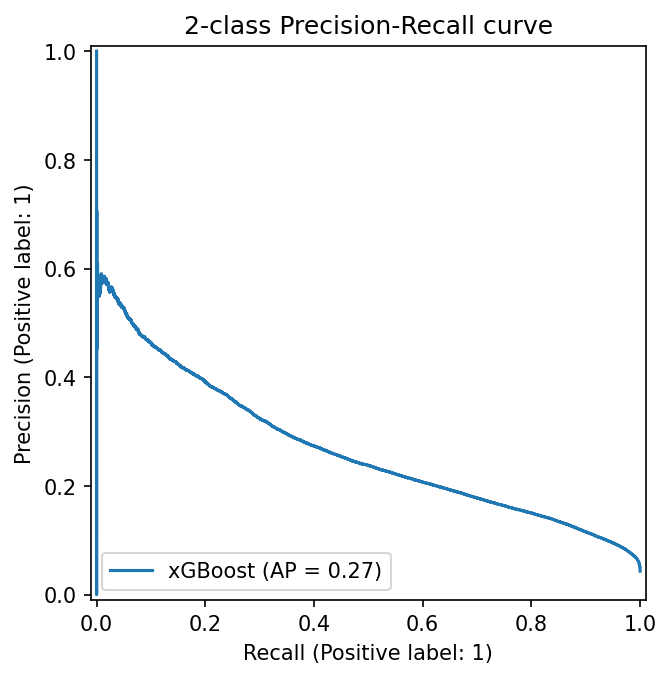

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, meso_val[all_features], meso_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
joblib.dump(model,'../models/random_forest_meso.pkl')